In [1]:
# Install detectron2
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.10 ; cuda:  1.10.2


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.modeling import build_model
import detectron2.utils as utils
from detectron2.data.detection_utils import build_augmentation

In [3]:
# Copyright (c) Facebook, Inc. and its affiliates.
import logging
import os
import sys
from collections import OrderedDict

import matplotlib.pyplot as plt
import torch
from torch.nn.parallel import DistributedDataParallel
import time
import datetime

from fvcore.common.timer import Timer
import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.config import get_cfg
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,)
from detectron2.engine import default_argument_parser, default_setup, launch
import detectron2.data.transforms as T

In [4]:
import shutil
import glob
import os
import pickle
import matplotlib.pyplot as plt
import cv2
import json
import requests
from PIL import Image
from matplotlib.pyplot import figure

In [32]:
import copy

class DefaultPredictor:
    """
    Create a simple end-to-end predictor with the given config that runs on
    single device for a single input image.

    Compared to using the model directly, this class does the following additions:

    1. Load checkpoint from `cfg.MODEL.WEIGHTS`.
    2. Always take BGR image as the input and apply conversion defined by `cfg.INPUT.FORMAT`.
    3. Apply resizing defined by `cfg.INPUT.{MIN,MAX}_SIZE_TEST`.
    4. Take one input image and produce a single output, instead of a batch.

    This is meant for simple demo purposes, so it does the above steps automatically.
    This is not meant for benchmarks or running complicated inference logic.
    If you'd like to do anything more complicated, please refer to its source code as
    examples to build and use the model manually.

    Attributes:
        metadata (Metadata): the metadata of the underlying dataset, obtained from
            cfg.DATASETS.TEST.

    Examples:
    ::
        pred = DefaultPredictor(cfg)
        inputs = cv2.imread("input.jpg")
        outputs = pred(inputs)
    """

    def __init__(self, cfg):  
#         # Simply needs to define some training transforms here
        self.cfg = cfg.clone()  # cfg can be modified by model
        self.model = build_model(self.cfg)
        self.model.eval()
        self.augmentation_train = build_augmentation(self.cfg, True)
        if len(cfg.DATASETS.TEST):
            self.metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

        checkpointer = DetectionCheckpointer(self.model)
        checkpointer.load(cfg.MODEL.WEIGHTS)
        self.input_format = cfg.INPUT.FORMAT
        assert self.input_format in ["RGB", "BGR"], self.input_format

        
    def __call__(self, original_image):
        """
        Args:
            original_image (np.ndarray): an image of shape (H, W, C) (in BGR order).

        Returns:
            predictions (dict):
                the output of the model for one image only.
                See :doc:`/tutorials/models` for details about the format.
        """
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            if self.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            aug_input = T.AugInput(copy.deepcopy(original_image), sem_seg=None)
            transforms = \
                self.augmentation_train[0](aug_input)
            image, sem_seg_gt = aug_input.image, aug_input.sem_seg
            image_shape = image.shape[:2]
            inputs = [{"image": torch.as_tensor(
            np.ascontiguousarray(image.transpose(2, 0, 1))), "height": height, "width": width}]
            
            print(image.shape)
            
            
            # print(inputs)
            images = self.model.preprocess_image(inputs)
            features = self.model.backbone(images.tensor)
            proposals_RPN, _ = self.model.proposal_generator(images, features, None)
            # predictions = self.model([inputs])[0]
            return proposals_RPN, inputs

In [33]:
def plot_RPN_proposals(file_name, input_image_index, batched_inputs, proposal_per_image, topk=None, save_img=None):
    RPN_top5_path = '/home/uzair.khattak/visualization/RPN_top5/'
    RPN_maxsize_path = '/home/uzair.khattak/visualization/RPN_maxscore/'
    color = (0, 0, 204)
    image = plt.imread(file_name)
    print(image.shape)
    
    # Now need to resize the image, based on transformed resized value
    H = batched_inputs[input_image_index]['image'].shape[2]
    W = batched_inputs[input_image_index]['image'].shape[1]
    image = cv2.resize(image, (H, W))
    # print('new image size', image.shape)
    # image = np.array(batched_inputs[input_image_index]['image'].permute(1, 2, 0).cpu())
    proposals = proposal_per_image[input_image_index]
    # If topk = False, meaning project the max size RPN proposal
    # Plot topk proposals of RPN on the given image
    # Based on confidence score
    if topk is not None:
        frame = None
        for i in range(topk):
            bbox = list(proposals[i].get_fields()['proposal_boxes'])[0].tolist()
            frame = cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 4)
        plt.figure(figsize=(16, 16))
        plt.axis('off')
        plt.imshow(frame)
        # plt.savefig('fig_max_rpn_s1b.png', bbox_inches='tight', pad_inches=0, transparent=True)
        plt.show()
    else:
        # Need to return the box with maximum size
        areas_per_proposal = []
        for i in range(32):
            single_bbox = list(proposals[i].get_fields()['proposal_boxes'])[0].tolist()
            area = (single_bbox[2] - single_bbox[0]) * (single_bbox[3] - single_bbox[1])
            areas_per_proposal.append(area)
        # Once done, we get index of maximum proposal
        max_proposal_index = np.argmax(areas_per_proposal, 0)
        # Retrieve the proposal details and plot it on the figure
        bbox = list(proposals[int(max_proposal_index)].get_fields()['proposal_boxes'])[0].tolist()
        frame = cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 4)
        plt.figure(figsize=(16, 16))
        plt.axis('off')
        plt.imshow(frame)
        # plt.savefig('fig_max_rpn_s1b.png', bbox_inches='tight', pad_inches=0, transparent=True)
        plt.show()

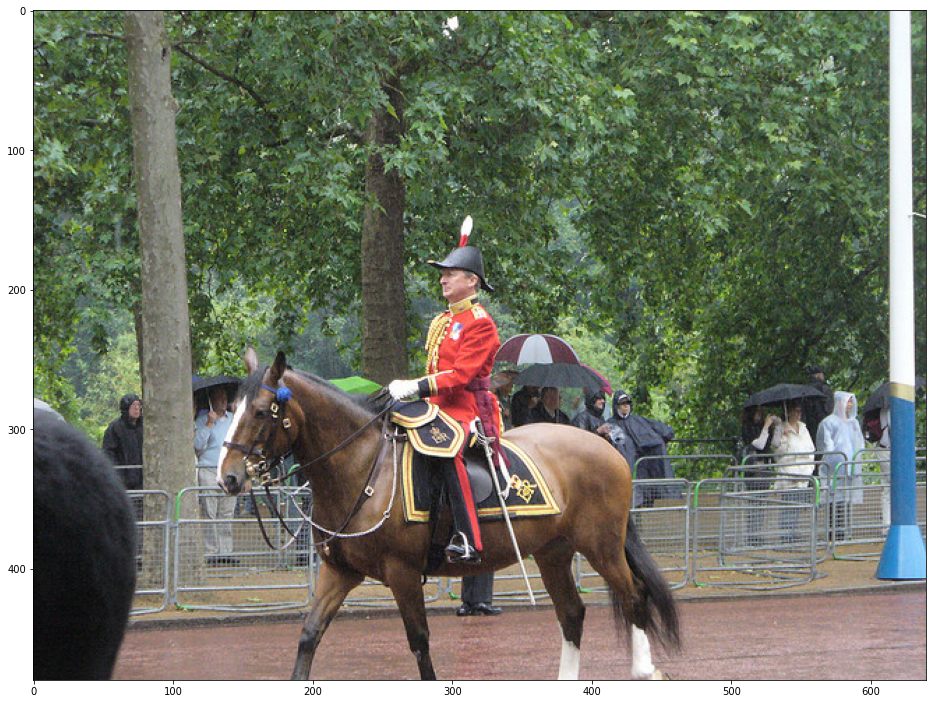

In [39]:
# It should return the proposals
import matplotlib.pyplot as plt
path = '/home/uzair.khattak/thesis/OD/Deformable-DETR/data/coco/val2017/'
image_id = '000000439715'
im = plt.imread(path + image_id + '.jpg')
plt.figure(figsize=(16, 16))
plt.imshow(im)

In [40]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

(736, 981, 3)


In [41]:
# SImply now need to pass it to default predictor
im = cv2.imread(path + image_id + '.jpg')
proposals, batched_inputs = predictor(im)

(736, 981, 3)


(480, 640, 3)


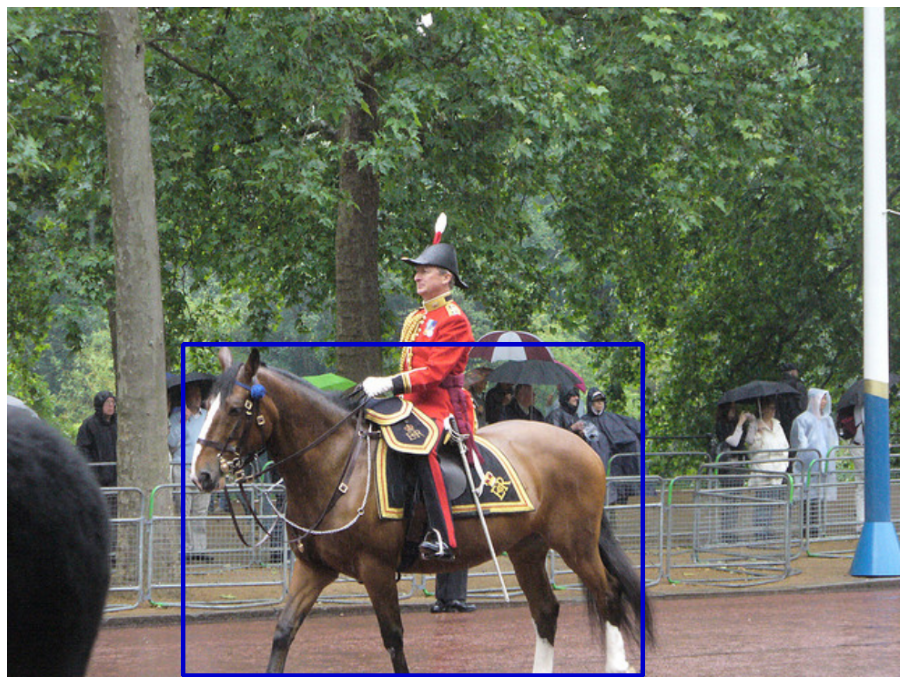

In [42]:
image_file_name = path + image_id + '.jpg'
# Maxbox
plot_RPN_proposals(image_file_name, 0, batched_inputs,proposals) 

(480, 640, 3)


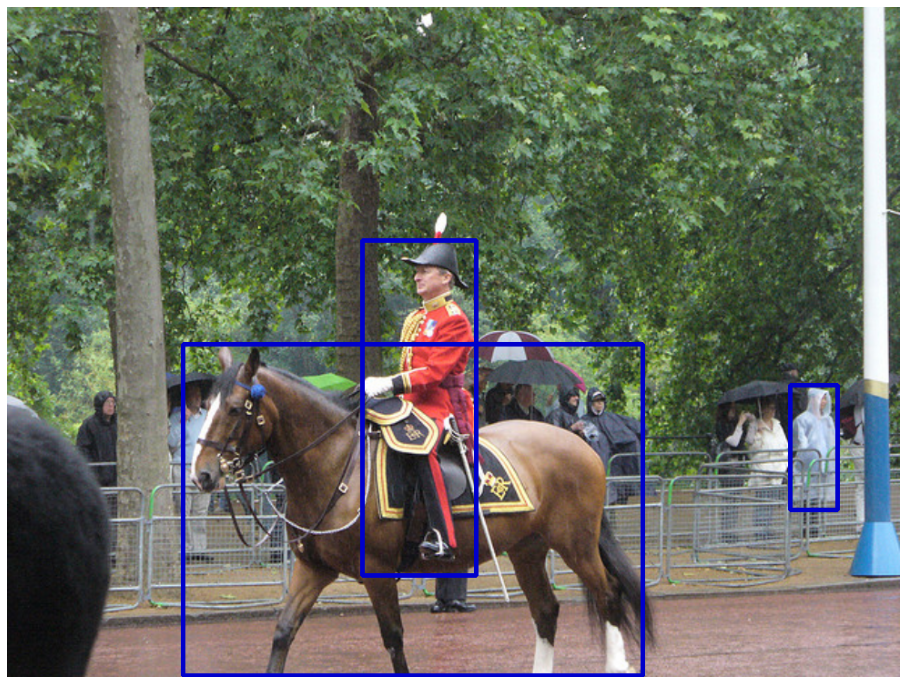

In [45]:
# TOP5
plot_RPN_proposals(image_file_name, 0, batched_inputs,proposals,3) 